# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In this project I built a pipeline to detect Lane Lines.


**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from math import pi

from helpers import read_images
from helpers import show_images

## Read test images

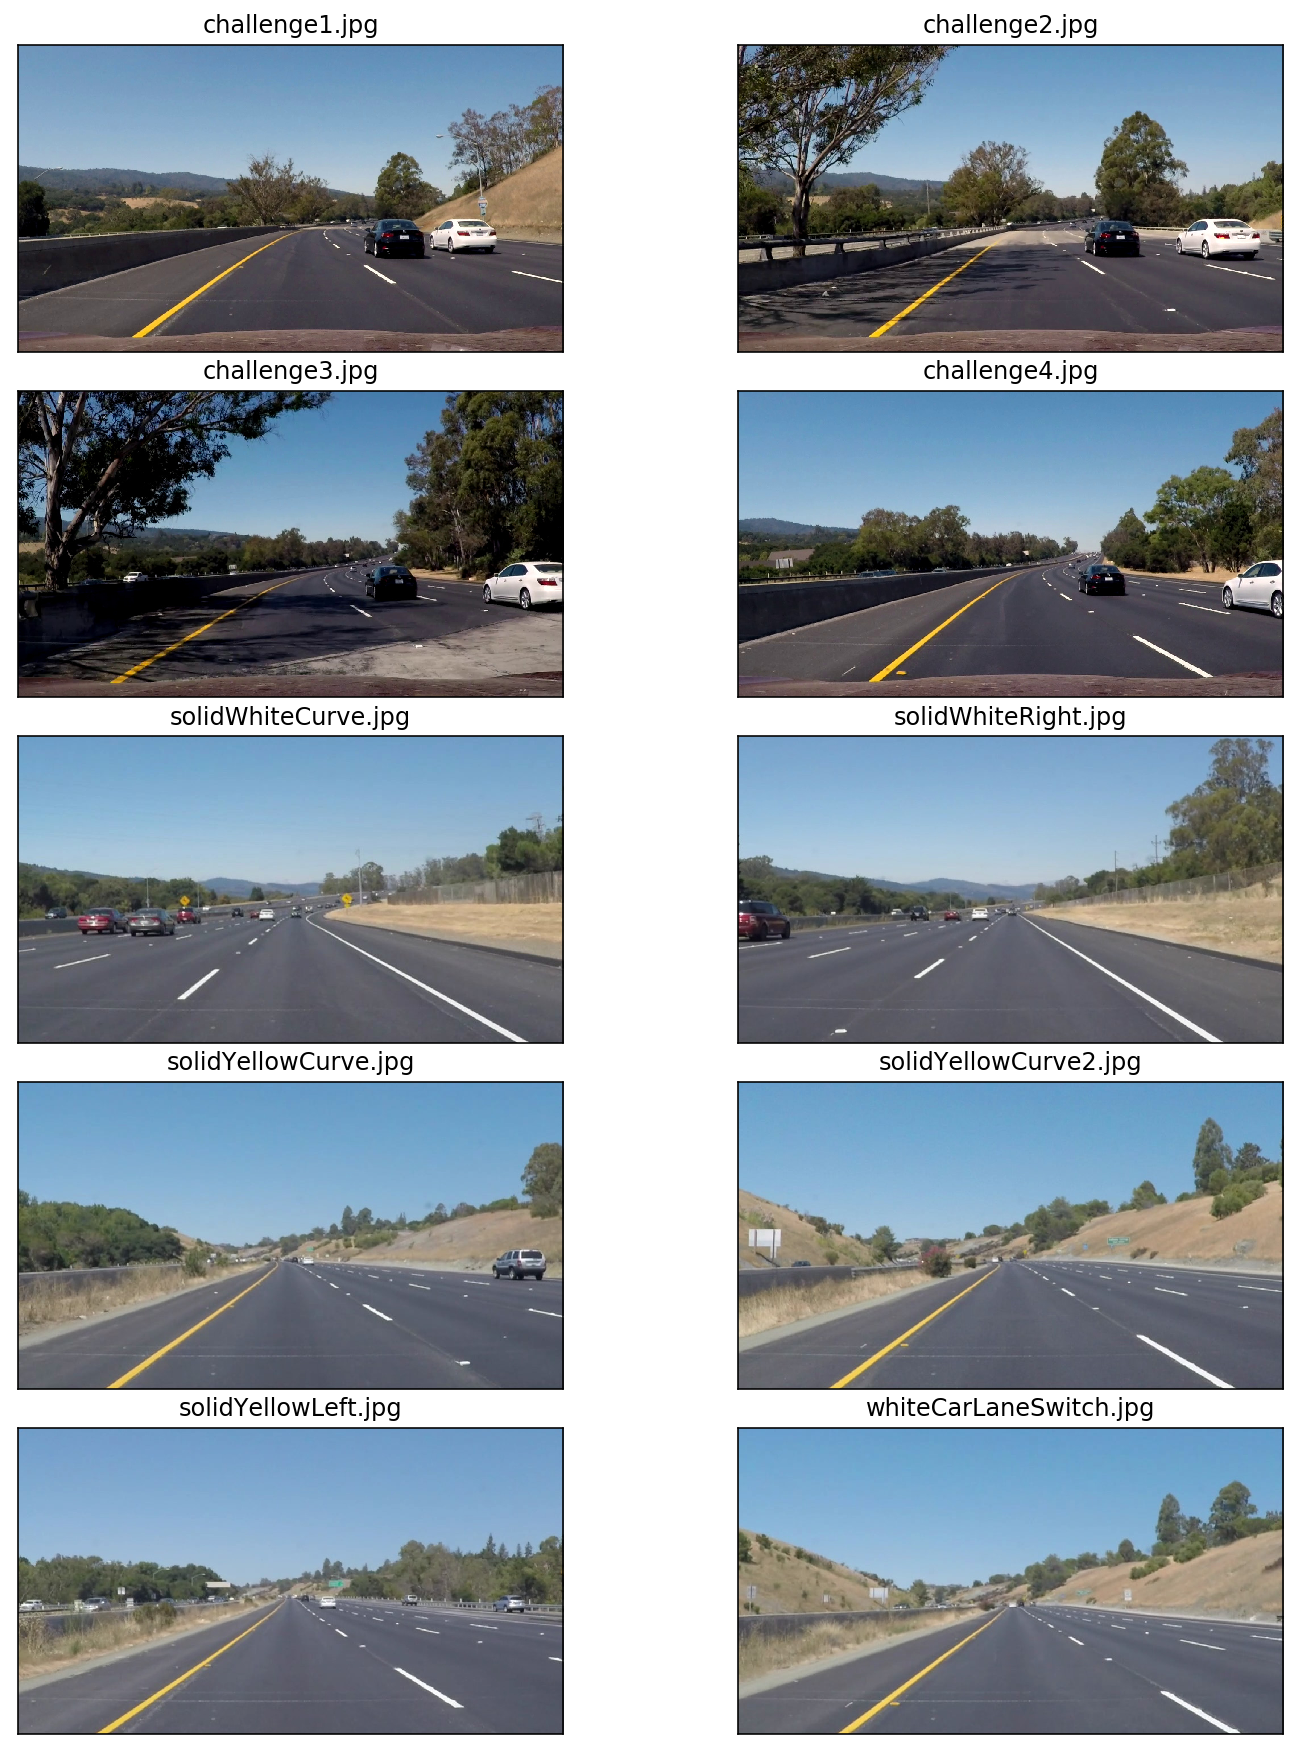

In [2]:
test_images = list(read_images('test_images'))
show_images(test_images)

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size, sigma):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def draw_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



## My pipeline
My pipeline consists of the following stages:
* binarization -- converts an input RGB image to a binary image. This step is neccessary because I use Hough transform to find lines.
* vectorization -- converts a binary image to a vector set. Hough transform is used here.
* processing -- finds lane lines (left and right) using the set of lines the previous step
* visualization -- just draws lane lines on the image

In [4]:
from collections import deque

class Pipeline:
    
    # canny parameters
    low_t = 20
    high_t = 100
    
    # gaussian parameters
    N = 15
    sigma = 0

    # region of interest
    region_top_width = 80
    region_bottom_width = 150

    # hough space parameters
    rho = 2
    theta = pi / 180

    # hough parameters
    threshold = 20
    min_line_len = 20
    max_line_gap = 400
    
    def __init__(self):
        self.processing = Processing()
        
    def __call__(self, image):
        binary_image = binary(image, self.low_t, self.high_t, self.N, self.sigma)
        
        lines = vectorize(binary_image, 
                          self.region_bottom_width, self.region_top_width,
                          self.rho, self.theta, 
                          self.threshold, self.min_line_len, self.max_line_gap)
        
        lane = self.processing(lines)
        
        lane.draw(image)
        
        return image

Functions that are used by Pipeline will be described below.

### Binarization
Binarization is a 3-step pipeline:
* color selection -- highlights "yellow" and "white" areas and "switches off" other pixels
* gaussian filtering -- eliminates additive noise
* Canny edge detection -- higlights edges

#### Color selection
As far as I understand, lane lines color is almost always yellow or white. As it is rather difficult to select yellow color in RGB color space, I switch to HLS color space. `hls` function (below) converts an image from RGB to HLS.

In [5]:
def hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

Let's apply `hls` function to test images:

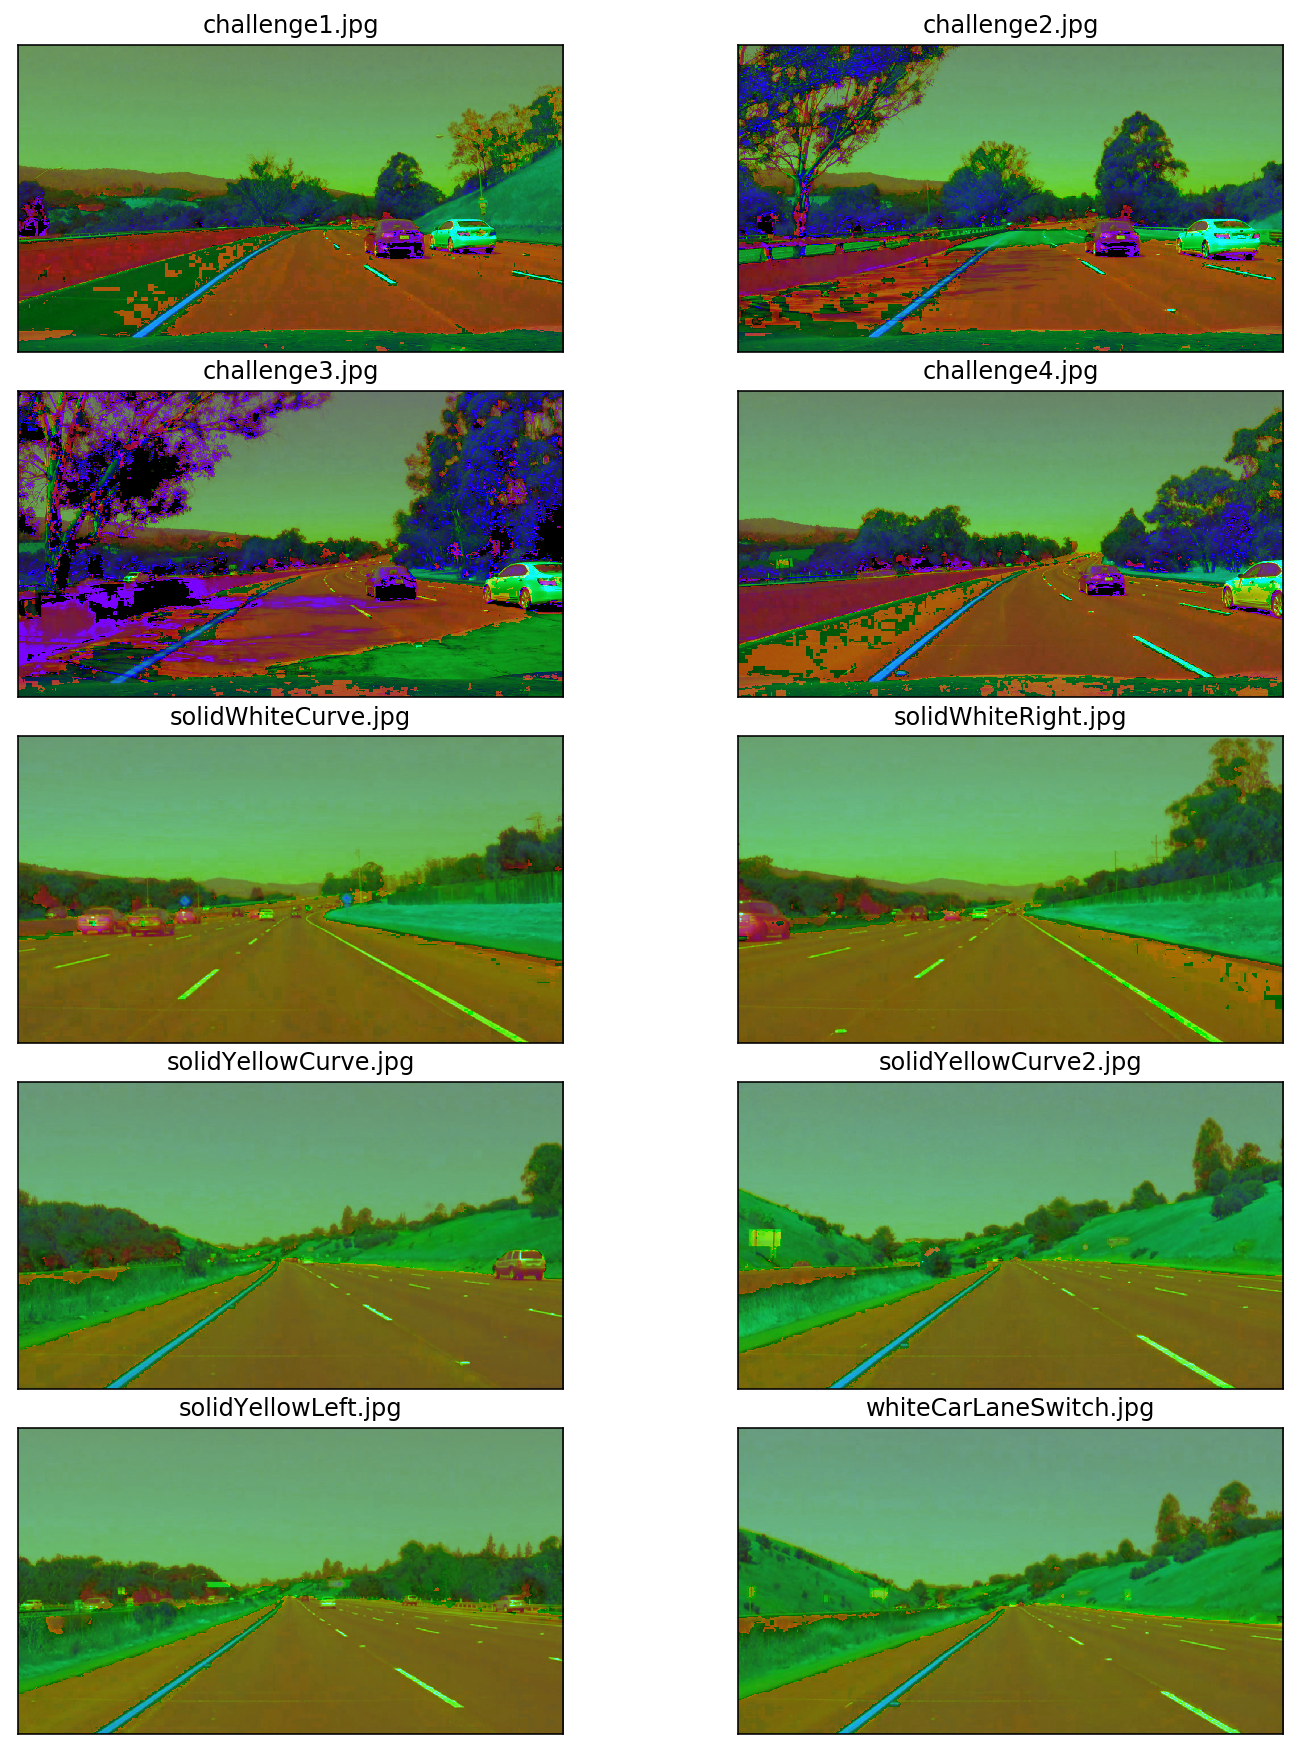

In [6]:
hls_images = [(image_name, hls(image)) for image_name, image in test_images]
show_images(hls_images)

As you can see, yellow and white lines are very clear. 

What is more, it is very important to use a suitable range for yellow and white colors. I found this range experimentally. See `hls_yellow_glass` and `hls_white_glass` below.

In [7]:
from collections import namedtuple

# type to describe colors in HLS color space
HLS = namedtuple('HLS', ['h', 'l', 's'])

class Glass:
    """Glass adjusts colors between lower and upper

    lower and upper must be a color in the same color space as image

    __call__ returns reflected image.
    """
    
    def __init__(self, lower, upper):
        self._lower = lower
        self._upper = upper

    def __call__(self, image):
        return cv2.inRange(image, self._lower, self._upper)
    
hls_yellow_glass = Glass(HLS(10, 0, 100), HLS(40, 255, 255))
hls_white_glass = Glass(HLS(0, 200, 0), HLS(255, 255, 255))

`hls_yellow_glass` and `hls_white_glass` are perfect if you want to select yellow or white separately =) But we need get both yellow and white at the same time. Function `mix` implements this logical "or":

In [8]:
def mix(image1, image2):
    return cv2.bitwise_or(image1, image2)

Finally, `select_yellow_and_white` implements the whole color selection algorithm:

In [9]:
def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

def select_yellow_and_white(image):
    """Selects yellow and white only
    
    Returns RGB image
    """
    hls_image = hls(image)
    yellow = hls_yellow_glass(hls_image)
    white = hls_white_glass(hls_image)
    mask = mix(yellow, white)
    return apply_mask(image, mask)

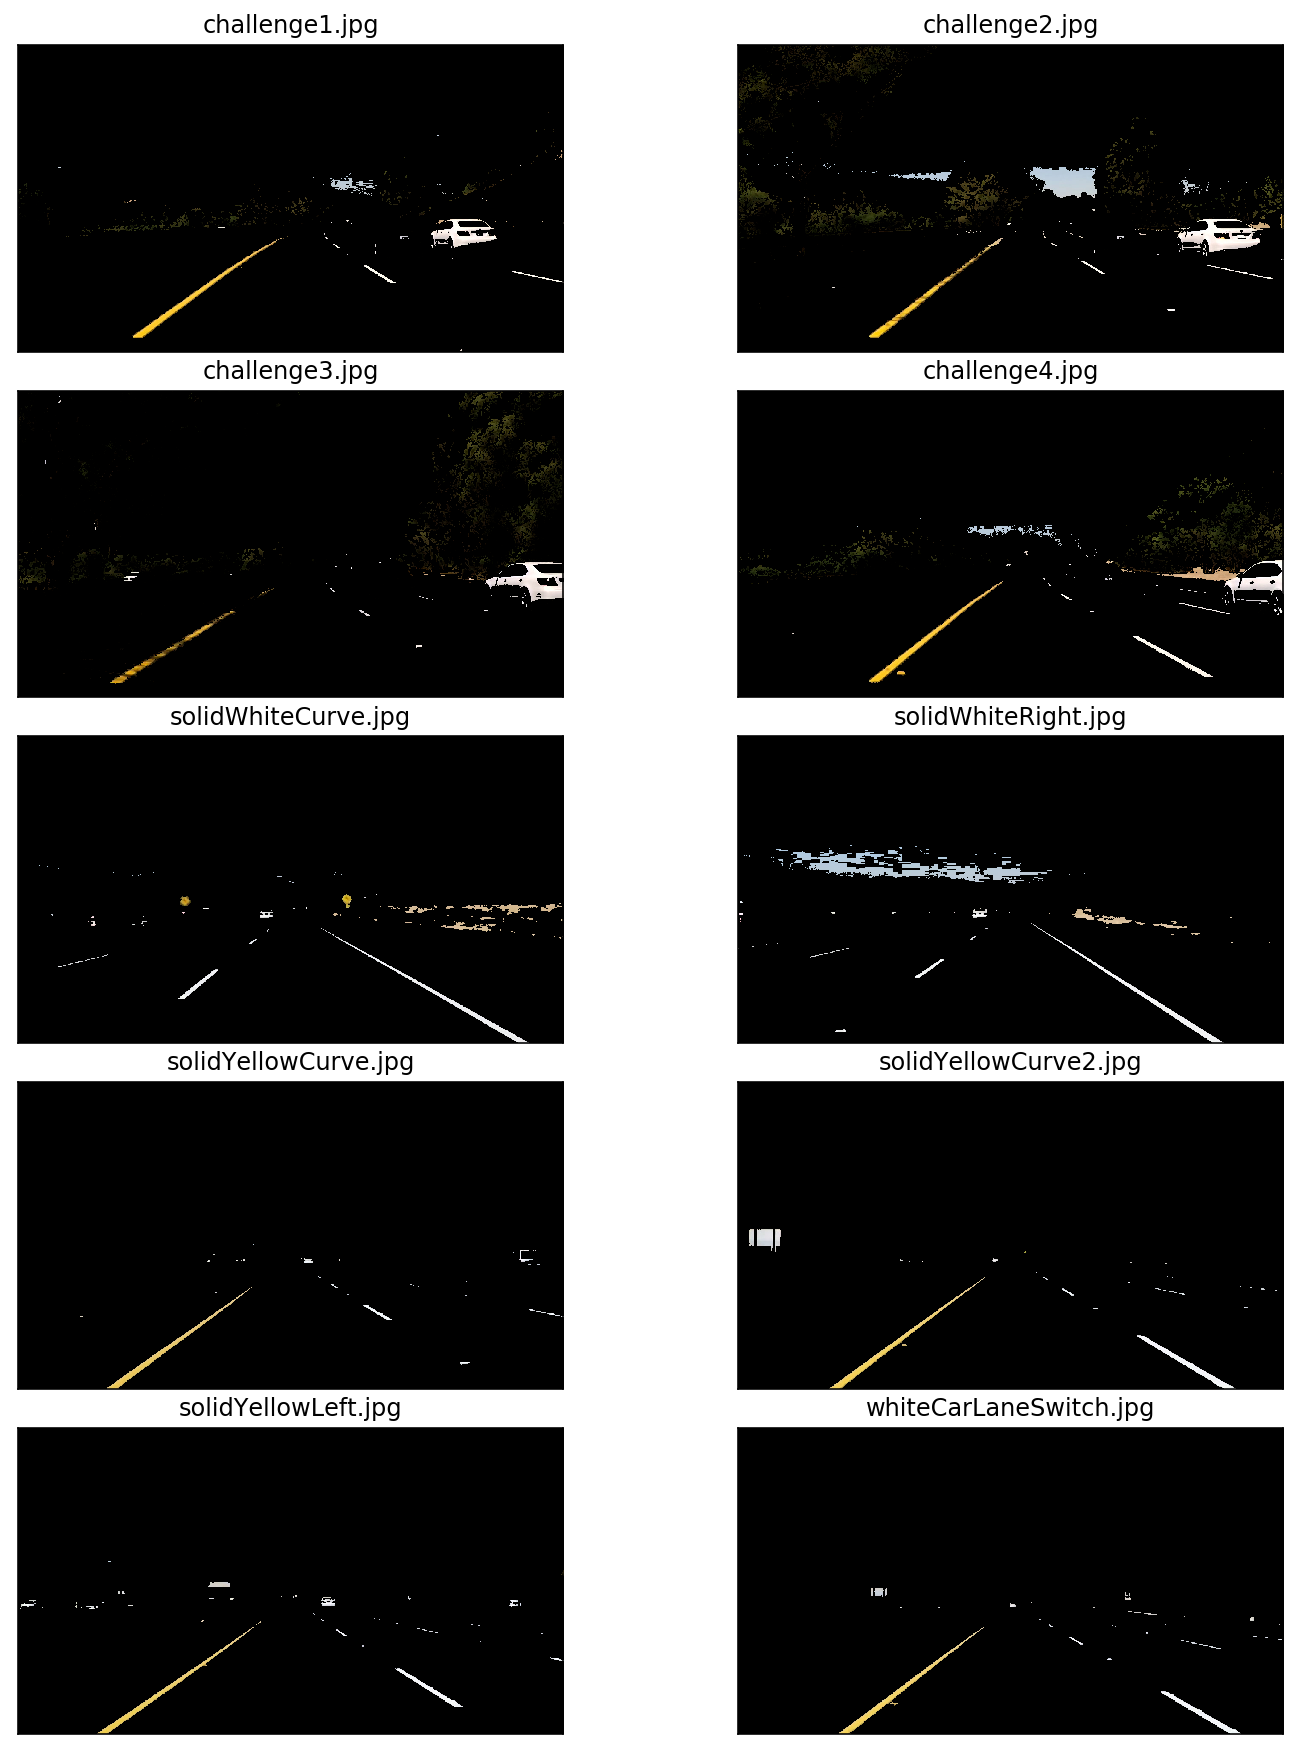

In [10]:
yellow_and_white = [(image_name, select_yellow_and_white(image)) for (image_name, image) in test_images]
show_images(yellow_and_white)

#### `binary` function

I use Canny edge detector to convert grayscale image to binary image. Canny edge detector is very sensible to additive noise. That is why I apply Gaussian filter before Canny.

The whole binarization step is implemented in `binary` function:

In [11]:
def binary(image, canny_low_t, canny_high_t, gauss_N, gauss_sigma):
    """Converts RGB image to binary image"""
    yellow_and_white = select_yellow_and_white(image)
    gray = grayscale(yellow_and_white)
    smoothed = gaussian_blur(gray, gauss_N, gauss_sigma)
    return canny(smoothed, canny_low_t, canny_high_t)

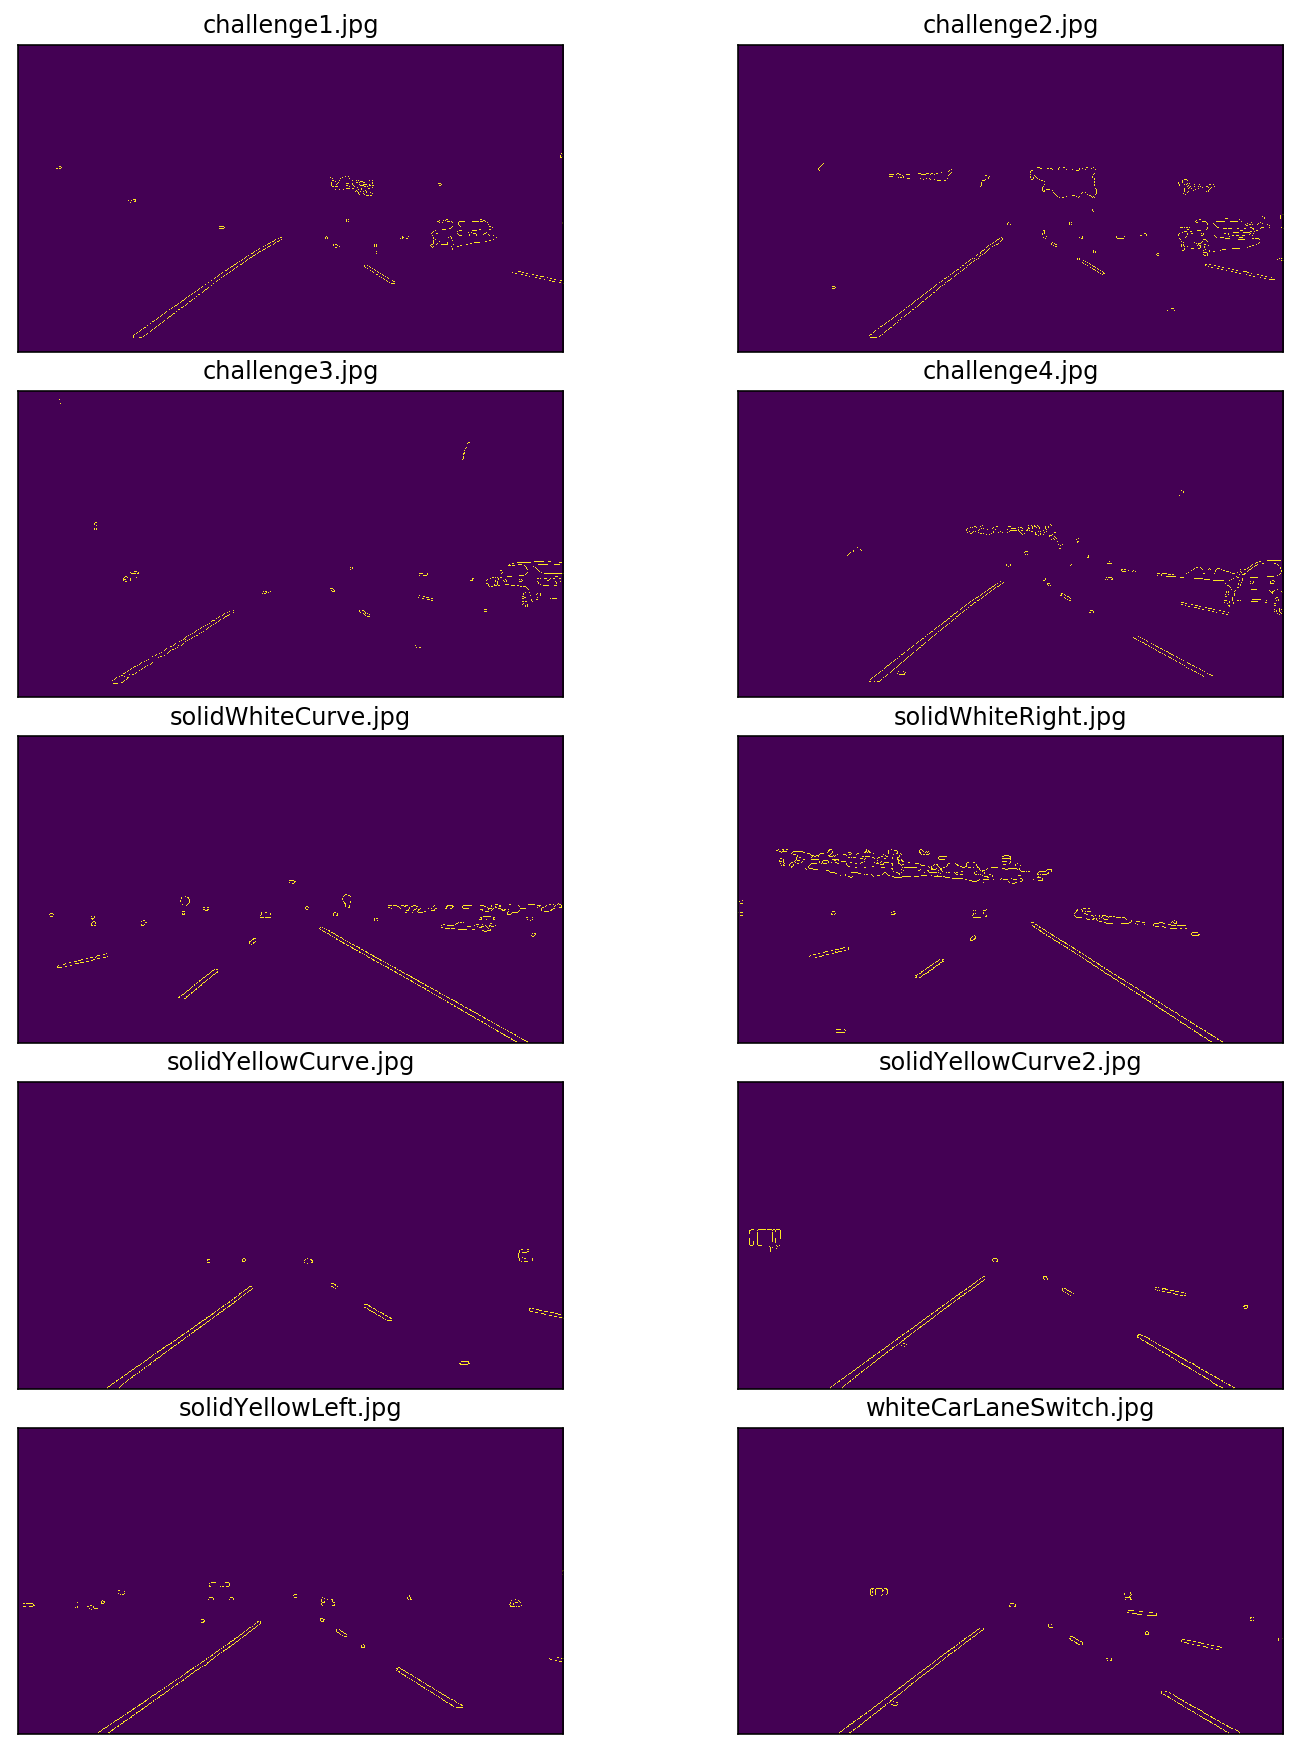

In [12]:
binary_images = [(image_name, binary(image, 20, 100, 15, 0)) for image_name, image in yellow_and_white]
show_images(binary_images)

### Vectorization
Hough transform is used to find a set of lines on the binary image.

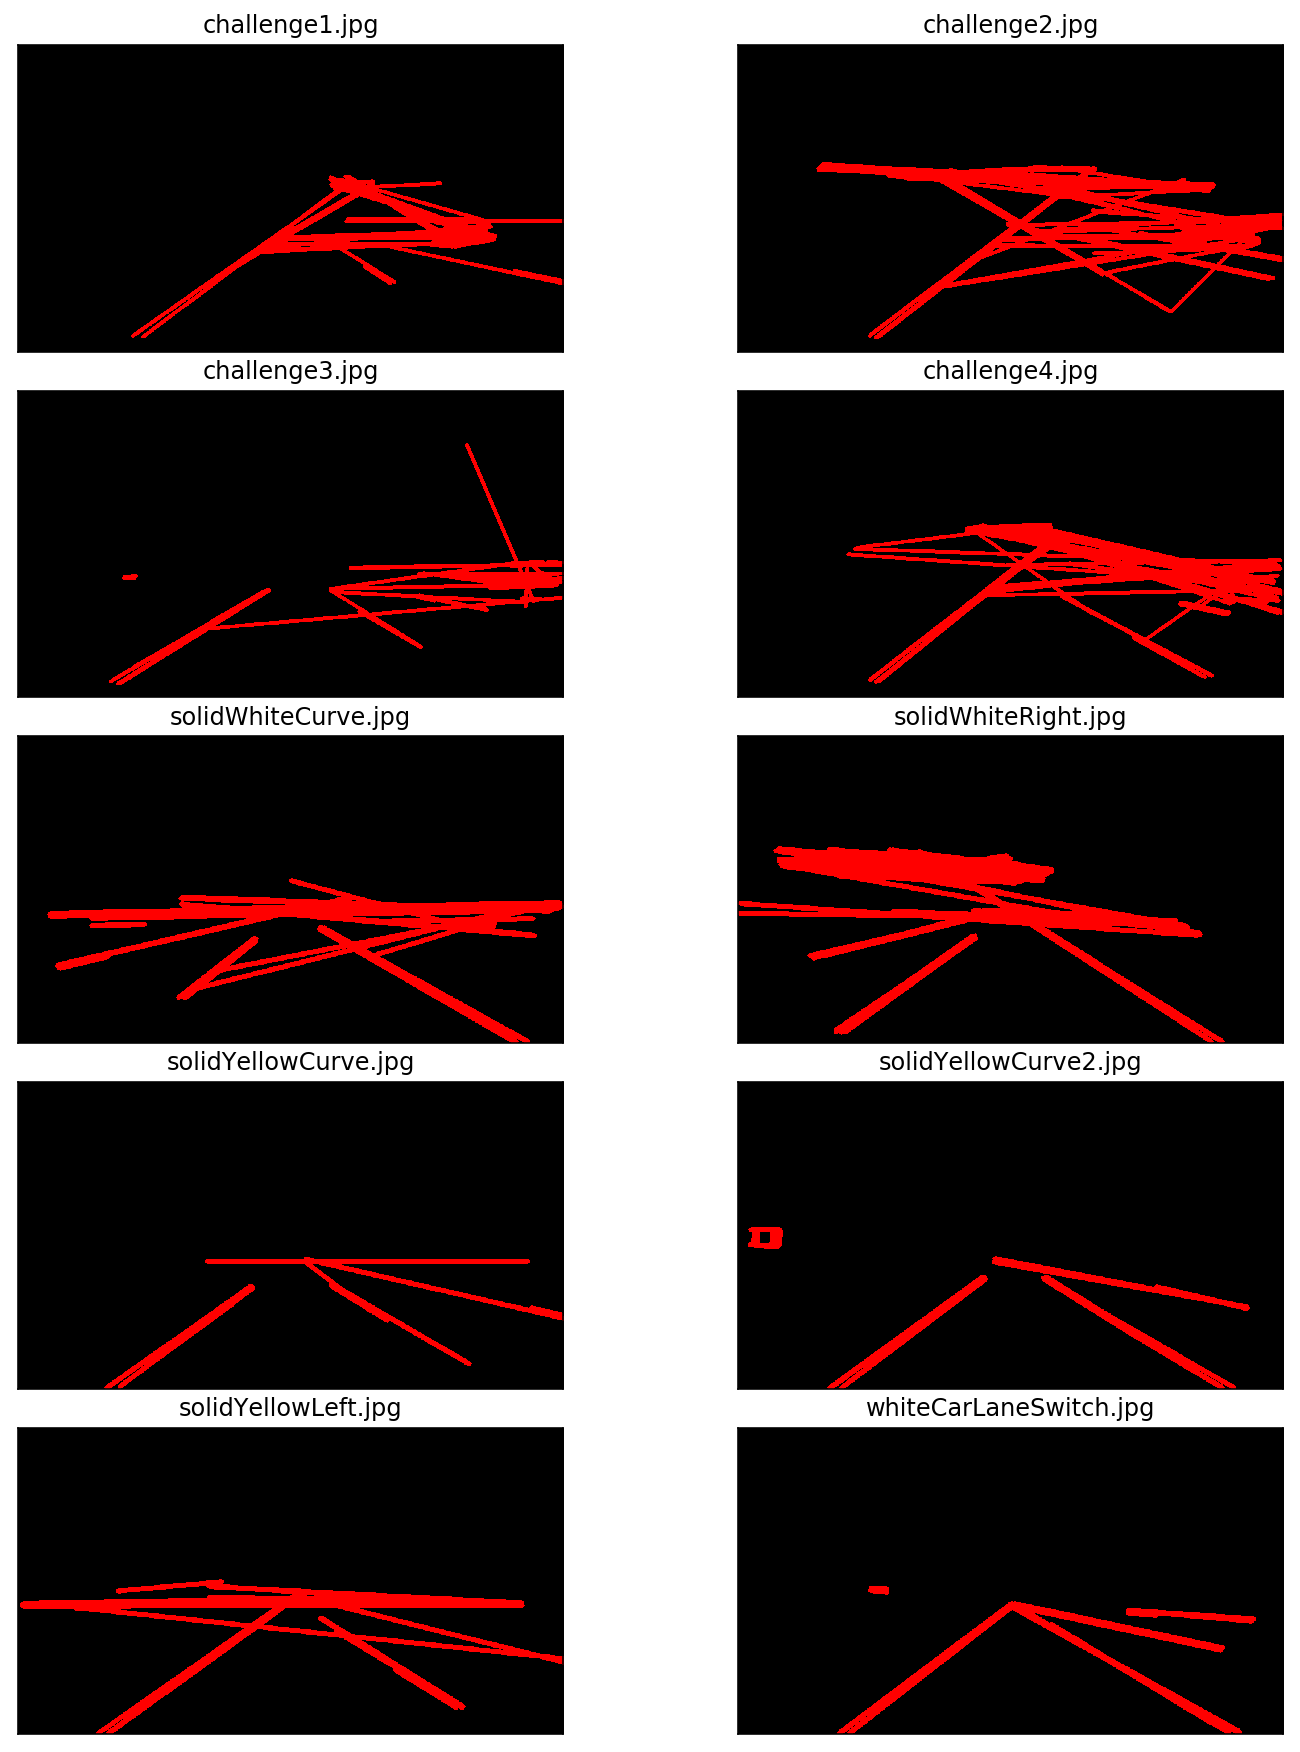

In [13]:
preview = [(image_name, draw_hough_lines(image, 1, pi / 180, 20, 20, 400)) for image_name, image in binary_images]
show_images(preview)

As you can see, it's very noisy. But it's possible to fix it using a "region of interest". I will use trapeze as a region of interest. `trapeze` function returns vertices of trapeze which I place in the center (by X axis) of the image. The height of trepeze will be half of image height. I've tried my best to explain. =)

In [14]:
def trapeze(image, bottom_width, top_width):
    height = image.shape[0]
    width = image.shape[1]

    x_middle = width / 2
    y_middle = height / 2

    vertices = [[
        (bottom_width / 2, height),
        (x_middle - top_width / 2, y_middle + top_width / 2), 
        (x_middle + top_width / 2, y_middle + top_width / 2),
        (width - bottom_width / 2, height)
    ]]
    
    return np.array(vertices, dtype=np.int32)

def trapeze_region(image, bottom_width, top_width):
    vertices = trapeze(image, bottom_width, top_width)
    return region_of_interest(image, vertices)

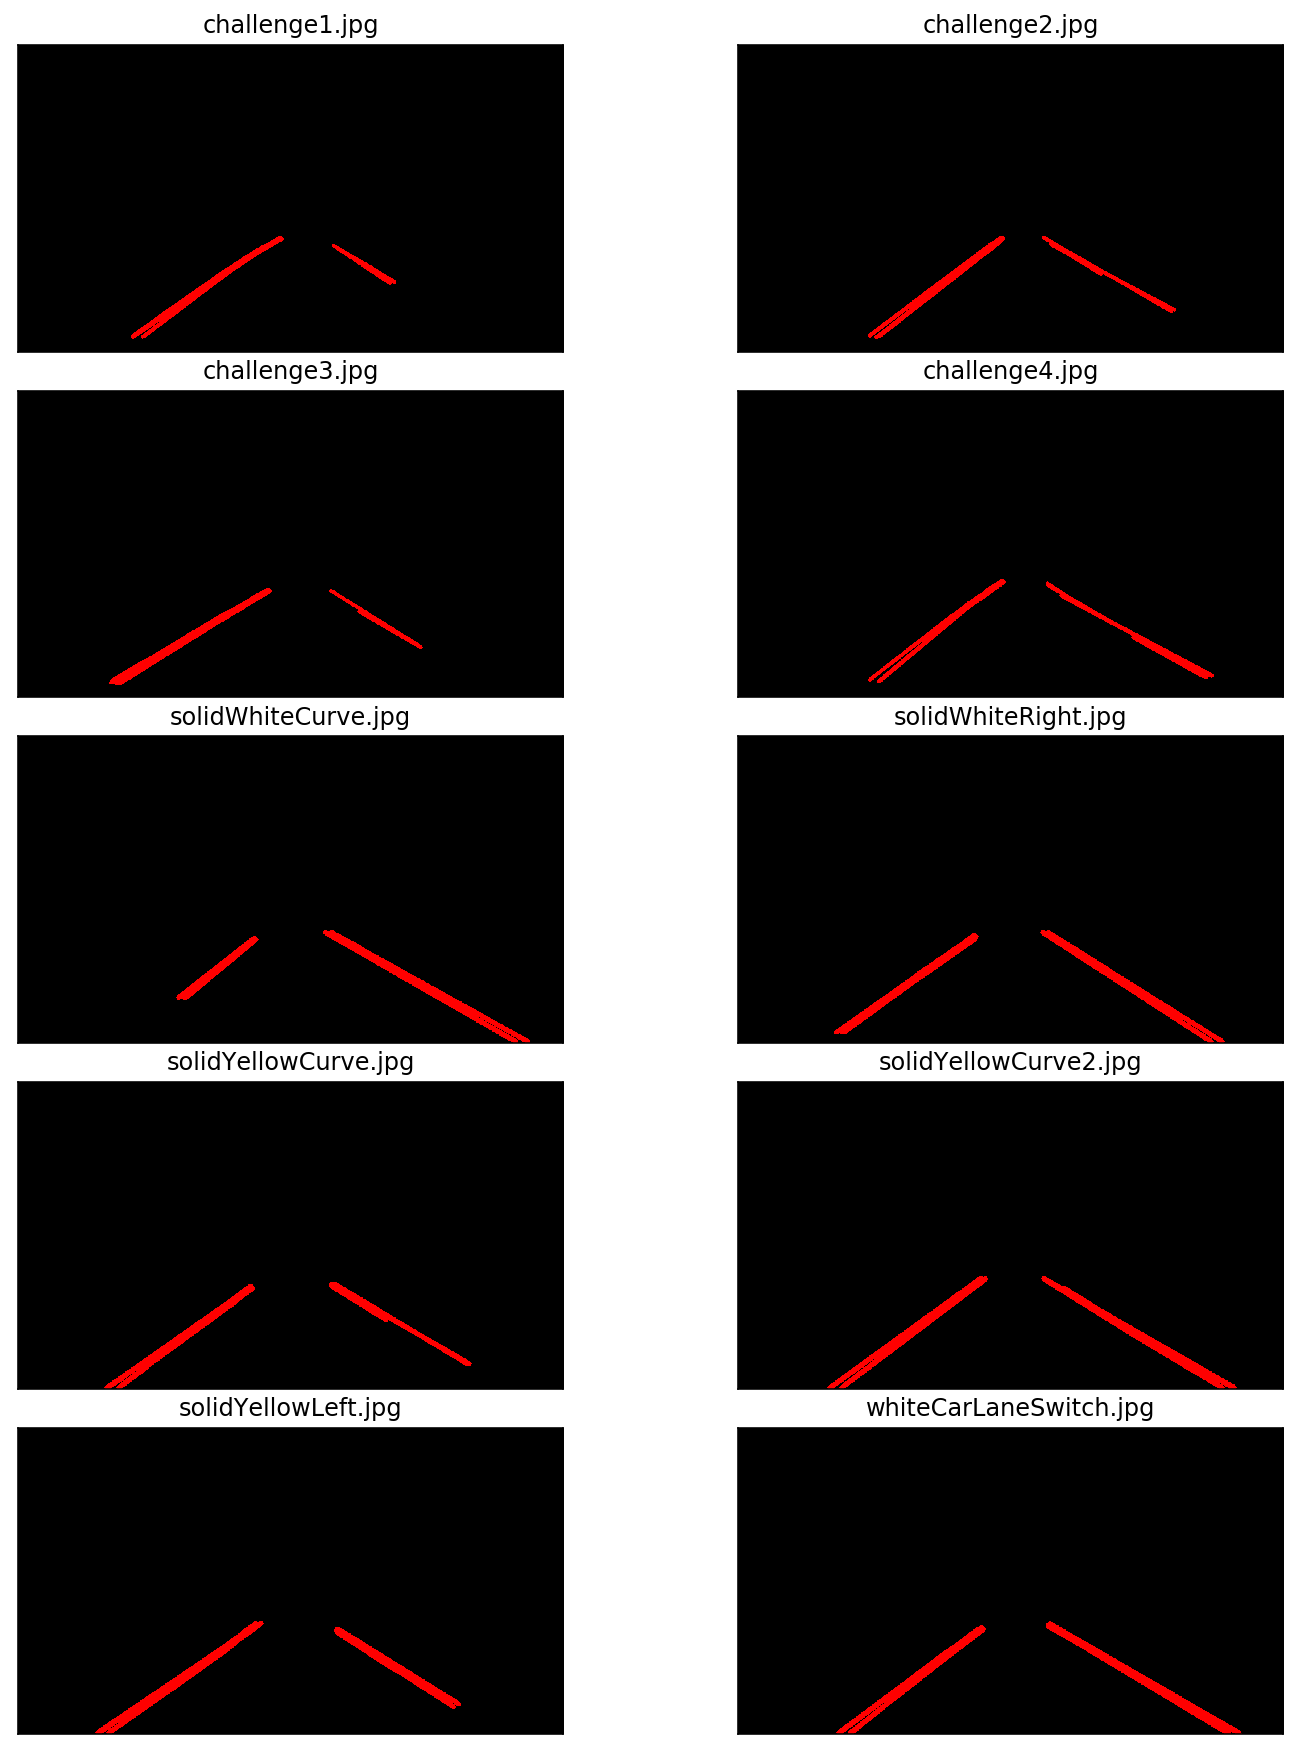

In [15]:
enhanced_preview = [(image_name, draw_hough_lines(trapeze_region(image, 80, 150), 1, pi / 180, 20, 20, 400)) for image_name, image in binary_images]
show_images(enhanced_preview)

#### `vectorize` function
The whole vectorization step is implemented in `vectorize` function:

In [16]:
def vectorize(binary_image, region_bottom_width, region_top_width,
              rho, theta, threshold, min_line_len, max_line_gap):
    """
    vectorize returns a set of lines as a NumPy array.
    """
    cropped = trapeze_region(binary_image, region_bottom_width, region_top_width)
    return hough_lines(cropped, rho, theta, threshold, min_line_len, max_line_gap)

## Processing

### Segment and ScopeInterceptLine models
Additional models are implemented to describe "line segments" and "lines".

`Segment` model describes a part of line bounded by two end points.

`ScopeInterceptLine` defines the `y = slope * x + intercept` line. `ScopeInterceptLine` contains `fit` method that returns the line segment and can be used to draw detected lane lines.


In [17]:
class Segment:
    
    VERTICAL_K = 3
    
    def __init__(self, coords):
        self._coords = coords   

    @property
    def x1(self):
        return self._coords[0]

    @property
    def y1(self):
        return self._coords[1]

    @property
    def x2(self):
        return self._coords[2]

    @property
    def y2(self):
        return self._coords[3]

    @property
    def is_vertical(self):
        return abs(self.x1 - self.x2) <= self.VERTICAL_K

    @property
    def slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1)

    @property
    def intercept(self):
        return self.y1 - self.slope * self.x1

    @property
    def length(self):
        return np.sqrt((self.y2 - self.y1)**2 + (self.x2 - self.x1)**2)

    def to_tuple(self):
        return tuple(self._coords)


class SlopeInterceptLine:

    def __init__(self, slope, intercept):
        assert slope != 0
        self.slope = slope
        self.intercept = intercept

    def fit(self, image, horizon=0.6):
        """Returns a line segment from bottom of image to horizon"""
        y1 = image.shape[0]
        y2 = y1 * horizon

        x1 = int((y1 - self.intercept) / self.slope)
        x2 = int((y2 - self.intercept) / self.slope)
        y1 = int(y1)
        y2 = int(y2)

        coords = np.array((x1, y1, x2, y2))
        
        return Segment(coords)    

An example:

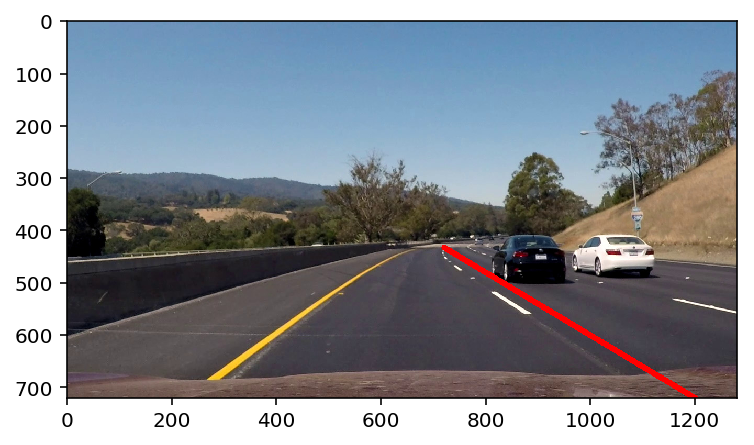

In [18]:
line = SlopeInterceptLine(0.6, 0)
image = np.copy(test_images[0][1])
segment = line.fit(image)
draw_lines(image, [[segment.to_tuple()]], thickness=10)
plt.imshow(image)

### Processing pipeline

Processing includes

* splitting Hough lines to "left" and "right". "Left" line is a line with a negative slope. "Right" line is a line with a positive slope. Vertical lines (their slope is almost zero) will be dropped

* stabilization -- finds the "mean lines" (one for "left" and one for "right" lane lines). `Stabilizator` stores some previously detected lane lines and uses them to suppress noise

`left_right_splitter` function implements "splitting". It uses `without_vertical` to wipe out vertical lines and sorts Hough lines into "left" and "right".

In [19]:
def without_vertical(lines):
    """Returns only "eligible" lines

    1. Vertical lines are not eligible
    2. There is no second condition =) I wanted to make more but I haven't had enough time

    Note: do not forget that this function converts numpy vectors to Segments
    """
    for line in lines:
        line_obj = Segment(line[0])
        if line_obj.is_vertical:
            continue # just drop all vertical lines
        yield line_obj

def left_right_splitter(lines):
    left_lines = []
    right_lines = []

    # drop vertical lines and split lines to "left" and "right"                                     
    for line in without_vertical(lines):
        if line.slope < 0:
            # left line
            left_lines.append(line)
        elif line.slope > 0:
            # right line
            right_lines.append(line)

    return left_lines, right_lines

`Stabilizer` implements "stabilization" and there is nothing to say more:

In [20]:
class Lane:
    def __init__(self, left, right):
        """
        left and right are SlopeInterceptLines
        """
        self.left = left
        self.right = right

    @property
    def found(self):
        return bool(self.left and self.right)
    
    def draw(self, image):
        left_segment = self.left.fit(image)
        right_segment = self.right.fit(image)
        draw_lines(image, [[left_segment.to_tuple()], [right_segment.to_tuple()]])

    
from operator import attrgetter

    
class Stabilizer:
    """Stabilizes Lane
    
    Stabilizer stores some of the previously detected lanes to smooth the current lane
    using "mean" smoothing.
    """

    def __init__(self, memory_size=20):
        self.left_candidates = deque(maxlen=memory_size)
        self.right_candidates = deque(maxlen=memory_size)

    def mean_line(self, candidates):
        if not candidates:
            return None
        
        mean_slope = np.mean(list(map(attrgetter("slope"), candidates)))
        mean_intercept = np.mean(list(map(attrgetter("intercept"), candidates)))

        return SlopeInterceptLine(mean_slope, mean_intercept)

    def __call__(self, left_candidates, right_candidates):
        left_mean_line = self.mean_line(left_candidates)
        if left_mean_line:
            self.left_candidates.append(left_mean_line)

        right_mean_line = self.mean_line(right_candidates)
        if right_mean_line:
            self.right_candidates.append(right_mean_line)

        return Lane(self.mean_line(self.left_candidates),
                    self.mean_line(self.right_candidates))

#### The whole processing pipeline

In [21]:
class Processing:
    
    def __init__(self):
        self.stabilizer = Stabilizer()
        
    def __call__(self, lines):
        """Applies Hough lines and returns Lane"""
        left_lines, right_lines = left_right_splitter(lines)
        
        lane = self.stabilizer(left_lines, right_lines)
        
        return lane

### Test Pipeline on Test Images

Note: I've added several frames from the "Challenge" clip.

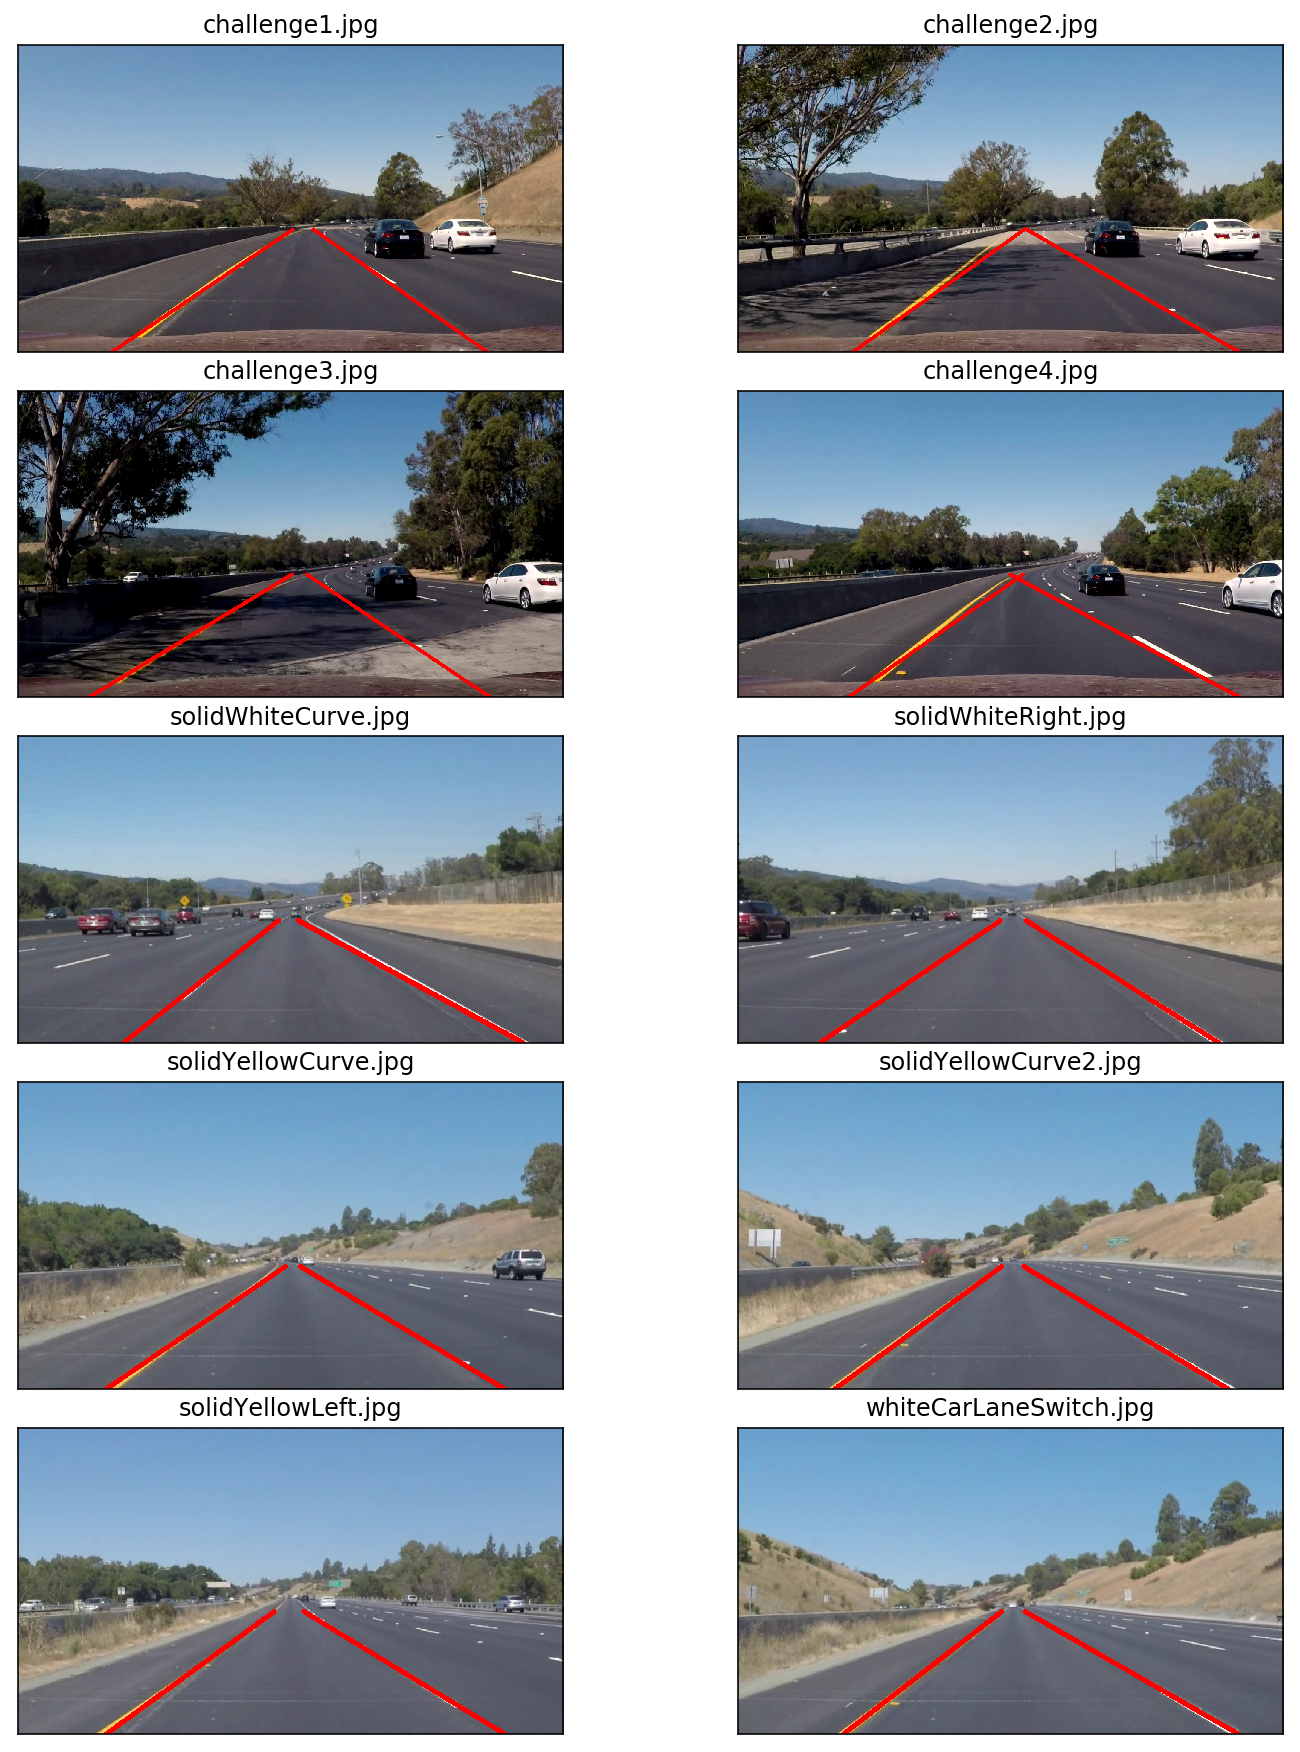

In [22]:
processed = []
for image_name, image in test_images:
    image = np.copy(image)
    pipeline = Pipeline()
    processed_image = pipeline(image)
    processed.append((image_name, processed_image))
show_images(processed)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os
from contextlib import suppress

with suppress(FileExistsError):
    os.makedirs("test_videos_output")

Let's try the one with the solid white lane on the right first ...

In [24]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
process_image = Pipeline()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 57.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.62 s, sys: 234 ms, total: 2.86 s
Wall time: 4.47 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
process_image = Pipeline()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 62.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.68 s, sys: 574 ms, total: 8.26 s
Wall time: 11.9 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [28]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
process_image = Pipeline()
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 32.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.76 s, sys: 329 ms, total: 5.09 s
Wall time: 8.58 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))